In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy


In [ ]:

#to transform images and to convert it in order to form to tensors
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}



In [ ]:
import io
import zipfile
!unzip /content/jpgtraintest.zip


Archive:  /content/jpgtraintest.zip
replace jpgtraintest/train/y/y91.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: jpgtraintest/train/y/y91.jpg  
  inflating: jpgtraintest/train/y/y53.jpg  
  inflating: jpgtraintest/train/y/y51.jpg  
  inflating: jpgtraintest/train/y/y107.jpg  
  inflating: jpgtraintest/train/y/y2.jpg  
  inflating: jpgtraintest/train/y/y6.jpg  
  inflating: jpgtraintest/train/y/y29.jpg  
  inflating: jpgtraintest/train/y/y5.jpg  
  inflating: jpgtraintest/train/y/y20.jpg  
  inflating: jpgtraintest/train/y/y104.jpg  
  inflating: jpgtraintest/train/y/y90.jpg  
  inflating: jpgtraintest/train/y/y93.jpg  
  inflating: jpgtraintest/train/y/y98.jpg  
  inflating: jpgtraintest/train/y/y43.jpg  
  inflating: jpgtraintest/train/y/y99.jpg  
  inflating: jpgtraintest/train/y/y1.jpg  
  inflating: jpgtraintest/train/y/y101.jpg  
  inflating: jpgtraintest/train/y/y39.jpg  
  inflating: jpgtraintest/train/y/y56.jpg  
  inflating: jpgtraintest/train/y/y62.jpg  
  infla

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join('/content/jpgtraintest', x), data_transforms[x]) for x in ['train', 'test']}

In [ ]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 176
    Root location: /content/jpgtraintest/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 44
    Root location: /content/jpgtraintest/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}
#HSN: data loader: python iterable dataset

In [ ]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f7ff3970898>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f7ff39707f0>}

In [ ]:
class_names = image_datasets['train'].classes

In [ ]:
class_names

['x', 'y']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#to use GPU version

In [ ]:
device

device(type='cpu')

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)


In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
#iter(dataloader) creates an object of class _DataLoaderIter and, in the loop, creates same object n times and retrieve the first batch only.

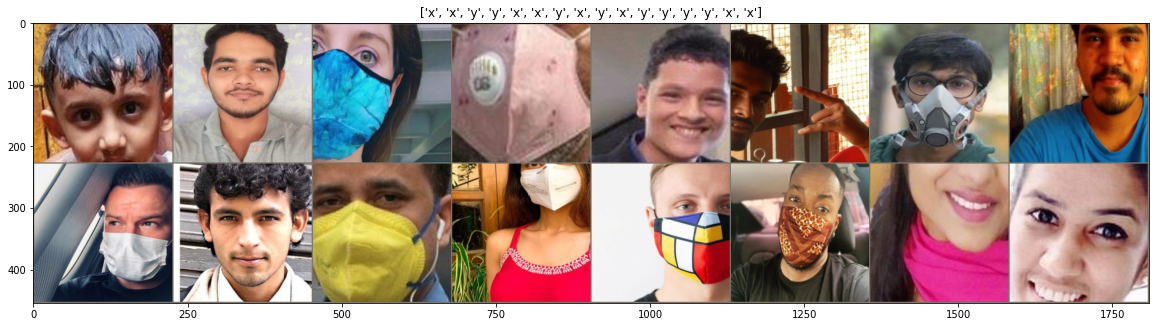

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    #HSN: making deep copy of model.
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                #HSN: Following the scheme to Decay LR by a factor of 0.1 every 7 epochs
                model.train()
                #HSNL model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. 
            else:
                model.eval()
                #HSN: model.eval() will notify all layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #HSN: Saving it to CUDA:0 GPU
                optimizer.zero_grad()
                #HSN: to clear the existing gradient
                #HSN: we need to set the gradients to zero before starting to do backpropragation
                
                with torch.set_grad_enabled(phase == 'train'):
                    #HSNL enable grad, based on train phase
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                     #HSN: maximum value of all elements in the input tensor.
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context



In [ ]:
model_ft = models.resnet101(pretrained=True)
#HSN: ResNet-101 model from Deep Residual Learning for Image Recognition
num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))
#HSN: in-feature for fc layer of resnet101

model_ft = model_ft.to(device)
#HSN: Model saved to CUDA:0 GPU
criterion = nn.CrossEntropyLoss()
#HSN: setting criterion as "training a classification problem with n number of classes".

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
#HSN: Implements Adagrad algorithm with Learning rate 0.001
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#HSN: Decays the learning rate of each parameter group by gamma every step_size epochs. This decay can happen simultaneously with other changes to the learning rate from outside this scheduler.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6167 Acc:0.7614

test Loss: 0.4687 Acc:0.8636

Epoch 1/19
----------
train Loss: 0.2390 Acc:0.8920

test Loss: 0.0172 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.1406 Acc:0.9489

test Loss: 0.0273 Acc:0.9773

Epoch 3/19
----------
train Loss: 0.2094 Acc:0.9148

test Loss: 0.0634 Acc:0.9773

Epoch 4/19
----------
train Loss: 0.0610 Acc:0.9773

test Loss: 0.0841 Acc:0.9545

Epoch 5/19
----------
train Loss: 0.0669 Acc:0.9773

test Loss: 0.0356 Acc:0.9773

Epoch 6/19
----------
train Loss: 0.0569 Acc:0.9716

test Loss: 0.0379 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0829 Acc:0.9602

test Loss: 0.0331 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0471 Acc:0.9773

test Loss: 0.0309 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0631 Acc:0.9773

test Loss: 0.0319 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.1160 Acc:0.9545

test Loss: 0.0252 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0644 Acc:0.9659

test Loss: 0.0248 Acc:1.0000

Epoch 12/19
----------
t

In [ ]:
torch.save(model_ft, 'x.pth')

In [ ]:
model = None

def load_model():
    global model
    filepath = 'x.pth'
    model = torch.load(filepath)
    class_names = ['without_mask','with_mask']

In [ ]:

import pickle
import numpy as np
from flask import Flask, request

model = None
app = Flask(__name__)

model = None
def load_model():
    global model
    filepath = 'x.pth'
    model = torch.load(filepath)
    class_names = ['without_mask','with_mask']

@app.route('/')
def home_endpoint():
    return 'Hello World!'


@app.route('/predict', methods=['POST'])
def get_prediction():
    # Works only for a single sample
    if request.method == 'POST':
        data = request.get_json()  # Get data posted as a json
        data = np.array(data)[np.newaxis, :]  # converts shape from (4,) to (1, 4)
        prediction = model.predict(data)  # runs globally loaded model on the data
    return str(prediction[0])


if __name__ == '__main__':
    load_model()  # load model at the beginning once only
    app.run(host='0.0.0.0', port=80)

NameError: ignored